In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import numpy as np
from scipy.sparse import csr_matrix

from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, label_binarize, StandardScaler
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import shuffle

In [2]:
df = pd.read_csv('log2.csv') 

In [3]:
df.isna().sum()

Source Port             0
Destination Port        0
NAT Source Port         0
NAT Destination Port    0
Action                  0
Bytes                   0
Bytes Sent              0
Bytes Received          0
Packets                 0
Elapsed Time (sec)      0
pkts_sent               0
pkts_received           0
dtype: int64

In [4]:
for column in df.columns:
    unique_values = len(df[column].unique())
    print(column,'=',unique_values)

Source Port = 22724
Destination Port = 3273
NAT Source Port = 29152
NAT Destination Port = 2533
Action = 4
Bytes = 10724
Bytes Sent = 6683
Bytes Received = 8814
Packets = 1116
Elapsed Time (sec) = 915
pkts_sent = 749
pkts_received = 922


Action
allow         37640
deny          14987
drop          12851
reset-both       54
Name: count, dtype: int64


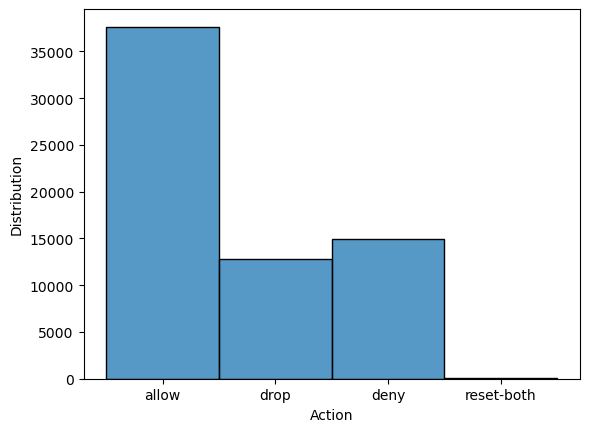

In [5]:
print(df['Action'].value_counts())
sns.histplot(data=df, x='Action')
plt.xlabel('Action')
plt.ylabel('Distribution')
plt.show()

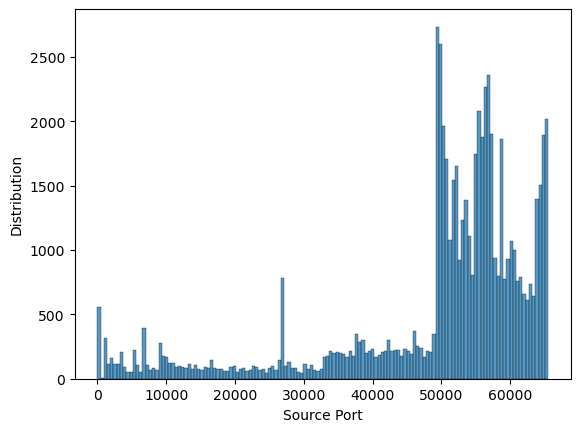

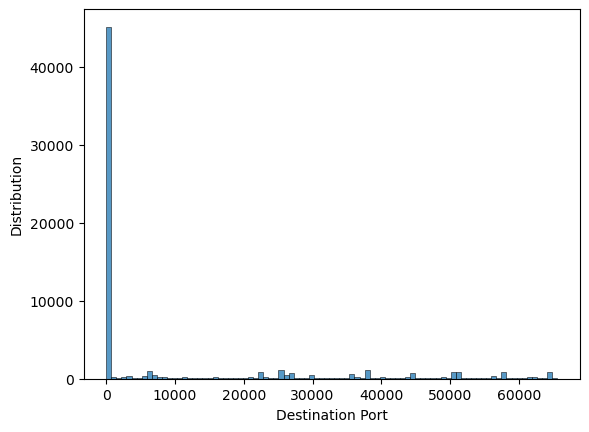

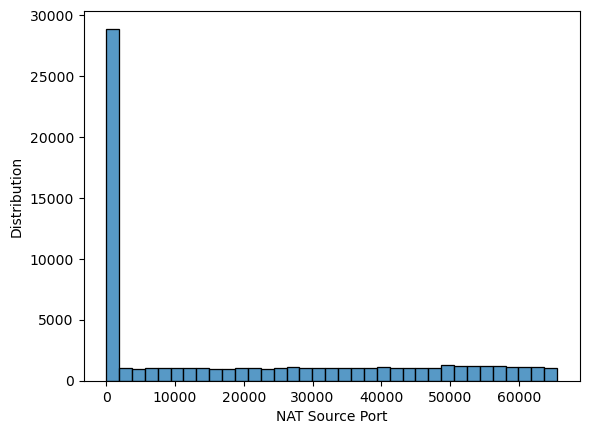

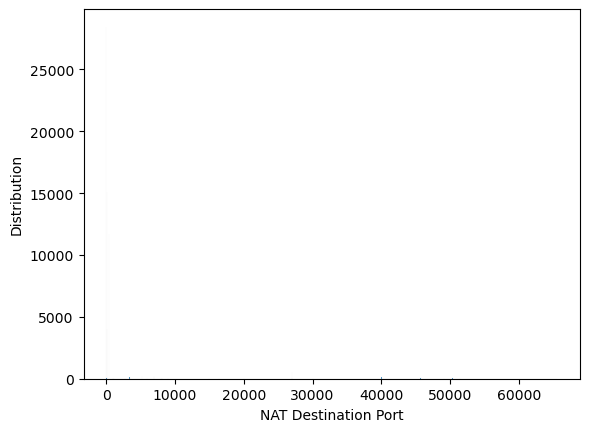

In [6]:
sns.histplot(data=df, x='Source Port')
plt.xlabel('Source Port')
plt.ylabel('Distribution')
plt.show()

sns.histplot(data=df, x='Destination Port')
plt.xlabel('Destination Port')
plt.ylabel('Distribution')
plt.show()

sns.histplot(data=df, x='NAT Source Port')
plt.xlabel('NAT Source Port')
plt.ylabel('Distribution')
plt.show()

sns.histplot(data=df, x='NAT Destination Port')
plt.xlabel('NAT Destination Port')
plt.ylabel('Distribution')
plt.show()

In [7]:
le = LabelEncoder()
df['Action'] = le.fit_transform(df['Action'])
mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print('Mapping:\n',mapping)

Mapping:
 {'allow': 0, 'deny': 1, 'drop': 2, 'reset-both': 3}


In [8]:
columns_to_encode = ['Source Port', 'Destination Port', 'NAT Source Port', 'NAT Destination Port']

df_encoded = pd.get_dummies(df, columns=columns_to_encode, prefix=columns_to_encode)

df_encoded

,Action,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received,Source Port_0,Source Port_5,...,NAT Destination Port_64932,NAT Destination Port_65054,NAT Destination Port_65100,NAT Destination Port_65128,NAT Destination Port_65253,NAT Destination Port_65264,NAT Destination Port_65387,NAT Destination Port_65427,NAT Destination Port_65534,NAT Destination Port_65535
0,0,177,94,83,2,30,1,1,False,False,...,False,False,False,False,False,False,False,False,False,False
1,0,4768,1600,3168,19,17,10,9,False,False,...,False,False,False,False,False,False,False,False,False,False
2,0,238,118,120,2,1199,1,1,False,False,...,False,False,False,False,False,False,False,False,False,False
3,0,3327,1438,1889,15,17,8,7,False,False,...,False,False,False,False,False,False,False,False,False,False
4,0,25358,6778,18580,31,16,13,18,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65527,0,314,192,122,6,15,4,2,False,False,...,False,False,False,False,False,False,False,False,False,False
65528,0,4680740,67312,4613428,4675,77,985,3690,False,False,...,False,False,False,False,False,False,False,False,False,False
65529,2,70,70,0,1,0,1,0,False,False,...,False,False,False,False,False,False,False,False,False,False
65530,2,70,70,0,1,0,1,0,False,False,...,False,False,False,False,False,False,False,False,False,False


In [9]:
df_encoded = df_encoded.apply(lambda col: col.astype(int))
df_encoded


,Action,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received,Source Port_0,Source Port_5,...,NAT Destination Port_64932,NAT Destination Port_65054,NAT Destination Port_65100,NAT Destination Port_65128,NAT Destination Port_65253,NAT Destination Port_65264,NAT Destination Port_65387,NAT Destination Port_65427,NAT Destination Port_65534,NAT Destination Port_65535
0,0,177,94,83,2,30,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,4768,1600,3168,19,17,10,9,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,238,118,120,2,1199,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,3327,1438,1889,15,17,8,7,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,25358,6778,18580,31,16,13,18,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65527,0,314,192,122,6,15,4,2,0,0,...,0,0,0,0,0,0,0,0,0,0
65528,0,4680740,67312,4613428,4675,77,985,3690,0,0,...,0,0,0,0,0,0,0,0,0,0
65529,2,70,70,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
65530,2,70,70,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
X = df_encoded.drop(columns=['Action'])
y = df_encoded['Action']
X_sparse = csr_matrix(X)
X_train, X_test, y_train, y_test = train_test_split(X_sparse,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

In [11]:
cValues = [0.001, 0.01, 0.1, 1, 10, 100]
for c in cValues:
    svmModel = LinearSVC(dual=True,C=c)
    svmModel.fit(X_train,y_train)
    svmPred = svmModel.predict(X_test)
    print('=============================')
    print('C',c)
    print(classification_report(y_test,svmPred))
    print(confusion_matrix(y_test,svmPred))
    print('=============================')

C 0.001
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7545
           1       0.99      1.00      1.00      2994
           2       1.00      1.00      1.00      2562
           3       0.00      0.00      0.00         6

    accuracy                           1.00     13107
   macro avg       0.75      0.75      0.75     13107
weighted avg       1.00      1.00      1.00     13107

[[7532   13    0    0]
 [   0 2987    7    0]
 [   0    0 2562    0]
 [   3    3    0    0]]
C 0.01
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7545
           1       1.00      1.00      1.00      2994
           2       1.00      1.00      1.00      2562
           3       0.00      0.00      0.00         6

    accuracy                           1.00     13107
   macro avg       0.75      0.75      0.75     13107
weighted avg       1.00      1.00      1.00     13107

[[7534   11    0    0]

In [12]:
svmModel = LinearSVC(dual=True,class_weight='balanced',C=10)

In [13]:
svmModel.fit(X_train,y_train)
svmPred = svmModel.predict(X_test)
svmAcc = accuracy_score(y_test, svmPred)
print('SVM Accuracy:', svmAcc)


SVM Accuracy: 0.9982452124818799


In [14]:
svmConfMatrix = confusion_matrix(y_test,svmPred)
print(classification_report(y_test,svmPred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7545
           1       1.00      1.00      1.00      2994
           2       1.00      1.00      1.00      2562
           3       0.00      0.00      0.00         6

    accuracy                           1.00     13107
   macro avg       0.75      0.75      0.75     13107
weighted avg       1.00      1.00      1.00     13107



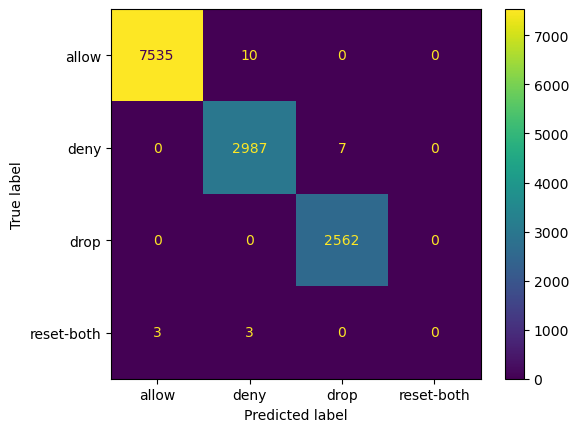

In [15]:
disp = ConfusionMatrixDisplay(confusion_matrix=svmConfMatrix,display_labels=le.classes_)
disp.plot()
plt.show()

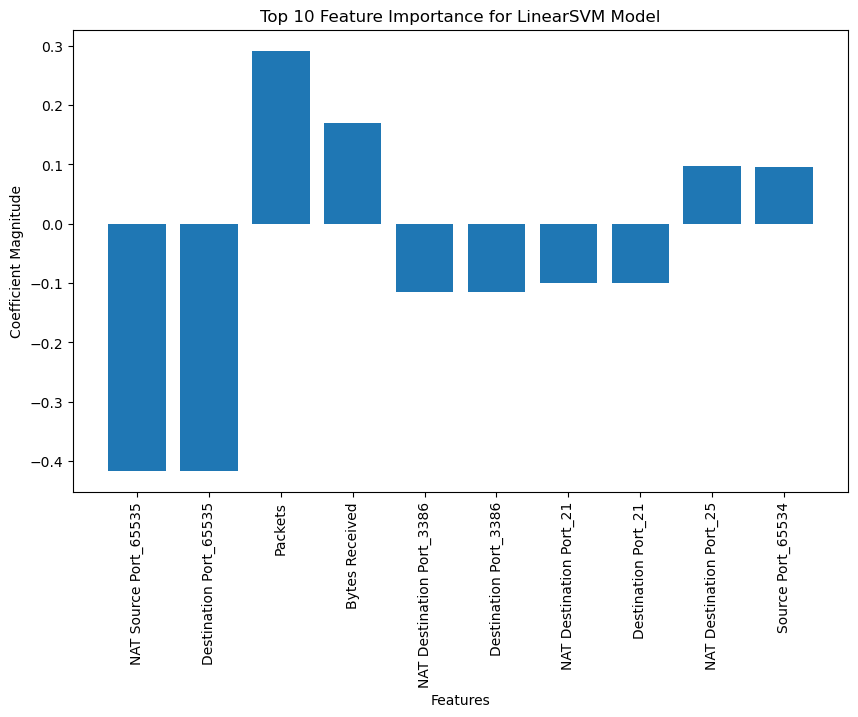

In [30]:
coefficients = svmModel.coef_[0]

feature_names = df_encoded.columns


non_zero_indices = np.where(coefficients != 0)[0]
non_zero_coefficients = coefficients[non_zero_indices]

sorted_indices = np.argsort(np.abs(non_zero_coefficients))[::-1][:10]
top_coefficients = non_zero_coefficients[sorted_indices]
top_feature_indices = non_zero_indices[sorted_indices]

top_feature_names = [feature_names[i] for i in top_feature_indices]

plt.figure(figsize = (10, 6))
plt.bar(range(len(top_feature_names)), 
        top_coefficients, 
        tick_label = top_feature_names)

plt.title('Top 10 Feature Importance for LinearSVM Model')
plt.xlabel('Features')
plt.ylabel('Coefficient Magnitude')

plt.xticks(rotation = 90)

plt.show()

In [16]:
sgdModel = SGDClassifier(early_stopping=True)

In [17]:
params = {'loss':['hinge','log_loss'],
          'alpha':[0.0001,0.001,0.01,0.1,1,10,100],
          }
sgdGS = GridSearchCV(estimator=sgdModel,
                     param_grid=params,
                     cv=5,
                     scoring='accuracy')
sgdGS.fit(X_train,y_train)
bestModel = sgdGS.best_estimator_
bestParams = sgdGS.best_params_
bestScore = sgdGS.best_score_

In [18]:
bestScore
bestParams

{'alpha': 0.1, 'loss': 'log_loss'}

In [19]:
sgdPred = cross_val_predict(bestModel,X_sparse,y,cv=5)


In [20]:
sgdModel2 = SGDClassifier(early_stopping=True, alpha=0.001, loss='log_loss')

In [21]:
sgdModel2.fit(X_train,y_train)
sgdPred = sgdModel2.predict(X_test)
sgdAcc = accuracy_score(y_test, sgdPred)
print('SGD Accuracy:',sgdAcc)


SGD Accuracy: 0.9951934081025406


In [24]:
print(classification_report(y_test, sgdPred))
sgdConfMatrix = confusion_matrix(y_test, sgdPred)

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      7545
           1       1.00      0.98      0.99      2994
           2       1.00      1.00      1.00      2562
           3       0.00      0.00      0.00         6

    accuracy                           1.00     13107
   macro avg       0.75      0.75      0.75     13107
weighted avg       0.99      1.00      0.99     13107



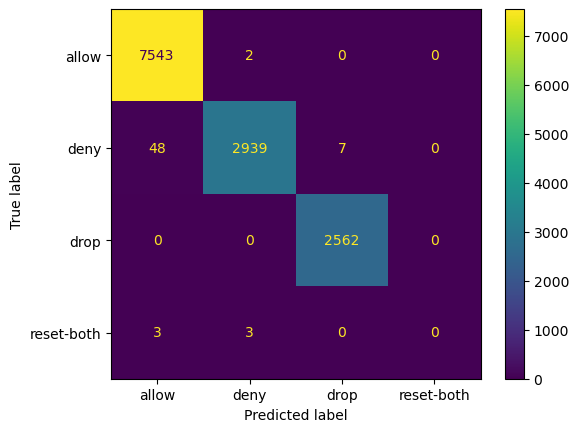

In [25]:
disp = ConfusionMatrixDisplay(confusion_matrix=sgdConfMatrix,display_labels=le.classes_)
disp.plot()
plt.show()

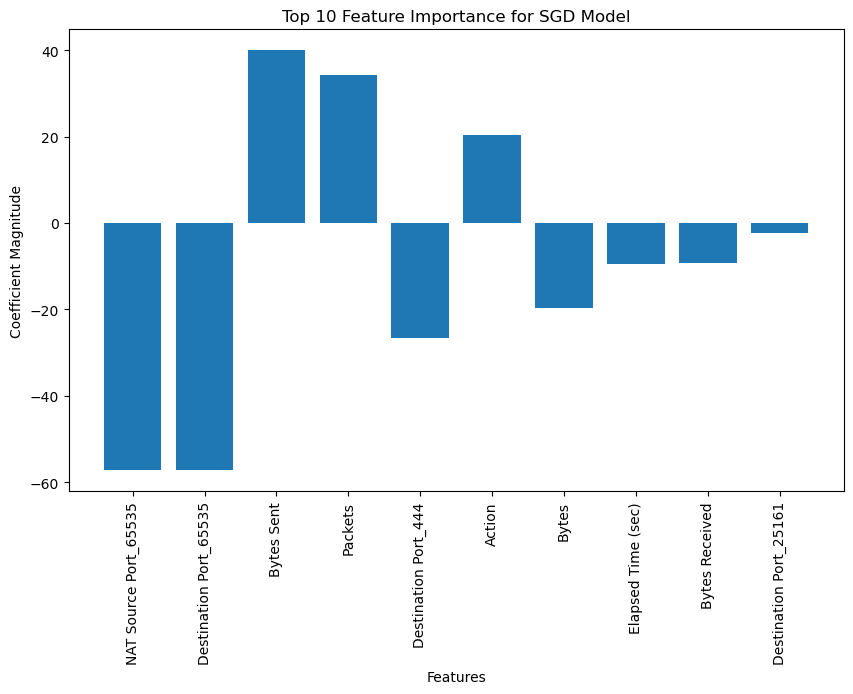

In [31]:
coefficients = sgdModel2.coef_[0]

your_feature_names = df_encoded.columns


non_zero_indices = np.where(coefficients != 0)[0]
non_zero_coefficients = coefficients[non_zero_indices]

sorted_indices = np.argsort(np.abs(non_zero_coefficients))[::-1][:10]
top_coefficients = non_zero_coefficients[sorted_indices]
top_feature_indices = non_zero_indices[sorted_indices]

top_feature_names = [feature_names[i] for i in top_feature_indices]

plt.figure(figsize = (10, 6))
plt.bar(range(len(top_feature_names)), 
        top_coefficients, 
        tick_label = top_feature_names)

plt.title('Top 10 Feature Importance for SGD Model')
plt.xlabel('Features')
plt.ylabel('Coefficient Magnitude')

plt.xticks(rotation = 90)

plt.show()